# <a id="top_section"></a>

<div align='center'><font size="6" color="#000000"><b> Image Recognition using CNN (explained !) </b></font></div>
<hr>
<div align='center'><font size="5" color="#000000">Introduction</font></div>
<hr>

When I started doing this problem my main goal was getting experience and to be able to explain whatver I learnt on the way. I'm still learning and trying to improve my skills, so every feedback and advices are welcome !
<br><br>
In this notebook I will try to show how to build a Digit Recognizer using Convolutional Neural Network(CNN) and will try to explain each step. If you are a beginner then this is the Notebook for you !

### Here are the things I will try to cover in this Notebook:

- What does our data look like ?
- What model should we choose or build?
- Which optimization technique to use?
- What is data augmentation ? Will it help in increasing the accuracy of our model?
- Is it possible to achieve 100% accuracy?

### If you like this kernel feel free to upvote and leave feedback, thanks!

![Image Recognier](https://miro.medium.com/max/372/1*AO2rIhzRYzFVQlFLx9DM9A.png)

<a id="toc_section"></a>
## Table of Contents
* [Introduction](#top_section)
* [Importing all the Required Libraries and Data](#section1)
* [Making our Data ready to be used](#section2)
    - [Shaping our data](#section3)
    - [Scaling our data](#section4)
    - [Encoding our data](#section5)
* [Building our CNN Model](#section6)
    - [Choosing an Optimizer](#section7)
    - [Building our model](#section8)
    - [Data Augmentation](#section9)
    - [Training our model](#section10)
    - [Accuracy and Loss plots](#section11)
    - [Accuracy report](#section12)
* [Submission & Some Last Words](#sectionlst)


<a id="section1"></a>
## Importing the libraries and Data


Let's start this notebook with importing all the necessary libraries we would need and the dataset.

In [1]:

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
sns.set_style()

# to divide our data into train and validation set
from sklearn.model_selection import train_test_split
#to encode our labels
from tensorflow.keras.utils import to_categorical
#to build our model 
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,Conv2D,MaxPool2D,Flatten,Dropout
# Our optimizer options
from keras.optimizers import RMSprop
from keras.optimizers import Adam
#Callback options
from tensorflow.keras.callbacks import EarlyStopping
from keras.callbacks import ReduceLROnPlateau
#importing image data generator for data augmentation
from tensorflow.keras.preprocessing.image import ImageDataGenerator
#for the final prediction report
from sklearn.metrics import classification_report ,confusion_matrix

In [2]:
train =pd.read_csv('../input/digit-recognizer/train.csv')
test=pd.read_csv('../input/digit-recognizer/test.csv')
y_train=train['label']
print(f'The size of training data is {train.shape[0]} and that of test data is {test.shape[0]}')

The size of training data is 42000 and that of test data is 28000


Ler's see our label column ! Basically it is the the column which labels our image as the number it is recognized as.

In [3]:
y_train

0        1
1        0
2        1
3        4
4        0
        ..
41995    0
41996    1
41997    7
41998    6
41999    9
Name: label, Length: 42000, dtype: int64

Let's set our features aside and see how it looks!

In [4]:
x_train=train.drop('label',axis=1).values
x_train

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

Let's just see a random image from our dataset ( I just used 41999 randomly , you can use any number).
- We will use the imshow(image show) function of matplotlib library here , you can use cmap as binary or Greys (they will get you the same image)
- we will reshape it to a image size that is 28 * 28 so that we can plot it from 728.

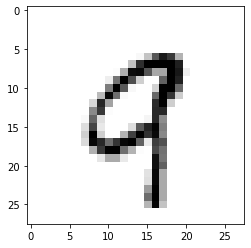

In [5]:
plt.imshow(x_train[41999].reshape(28,28),cmap='binary')
plt.show()

<a id="section2"></a>
## Making our Data to be used !


<a id="section3"></a>
## Shaping our data


Now we will reshape the whole x_train dataset.

In [6]:
x_train=x_train.reshape(42000,28,28)

Let's be sure that we did it right :P

In [7]:
x_train.shape

(42000, 28, 28)

Let's split our data into training and validation set , we will use the train_test_split function of sklearn library for this step.

![Data splitting chart](https://i.stack.imgur.com/pXAfX.png)

In [8]:

x_train,x_val,y_train,y_val=train_test_split(x_train,y_train,test_size=0.10,random_state=19)

Let's see how much data we have now in train and validation set !

In [9]:
print(f'The training set has {x_train.shape[0]} images and the validation set has {x_val.shape[0]} images')

The training set has 37800 images and the validation set has 4200 images


<a id="section4"></a>
## Encoding the Label column


As our label column has 10 possible values(0-9) we will encode it using the to_categorical function from the keras.
- We will use num_classes as 10 , as that is how many possible values the column can have.

In [10]:
y_cat_train=to_categorical(y_train,num_classes=10)
y_cat_val=to_categorical(y_val,num_classes=10)

Now let's plot a random image along with it's label.

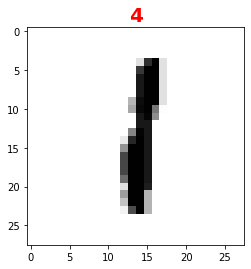

In [11]:
random_image=x_train[78]
random_label=y_train[78]
plt.imshow(random_image,cmap='binary')
plt.title(random_label,fontsize=20,weight='bold',color='red')
plt.show()

<a id="section3"></a>
## Scaling our data


Let's see what is the range of our data for the images. Simply the (max-min) value is range.

In [12]:
random_image.max()

255

In [13]:
random_image.min()

0

Clearly 255 is the range , so we will now use this value to scale our data ! 

In [14]:
x_train_scaled=x_train/255
x_val_scaled=x_val/255

But won't it affect the image? Same question was mine when i first thought about it but , NO , it won't ! Don't believe me ? See for yourself !

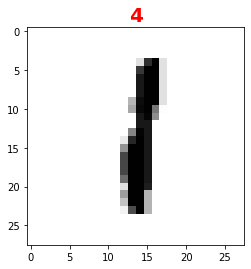

In [15]:
plt.imshow(x_train_scaled[78],cmap='binary')
plt.title(y_train[78],fontsize=20,weight='bold',color='red')
plt.show()

Okay so we are almost done , but to process the image we need to tell our model that our images are grey-scale , and we will do it by adding a 1 to the shape of our dataset.

In [16]:
x_train_final = x_train_scaled.reshape(x_train_scaled.shape[0],28,28,1)
x_val_final = x_val_scaled.reshape(x_val_scaled.shape[0],28,28,1)

<a id="section6"></a>
## Building our CNN Model


<a id="section7"></a>
## Choosing an optimizer


So there are a lot of optimizers out there and the most famous ones are Adam and RMSprop , 
> So what should we choose?

I tried both and RMSprop gave me better results for my model so I will be using RMSprop here , but you can also try Adam optimizer it's good too and maybe if you are using a different model Adam optimizer could work better for you model !

Let's set our RMSprop then :
- Setting learning rate to 0.001
- The value of rho to 0.9
- Epsilon to 10^-8
- Decay to zero

You can also read more about RMSprop [here](https://towardsdatascience.com/understanding-rmsprop-faster-neural-network-learning-62e116fcf29a).

In [17]:
optimizer = RMSprop(lr=0.001, rho=0.9, epsilon=1e-08, decay=0.0)

<a id="section8"></a>
## Building our model

So it's all set now let's build our model shall we?
I tried various models and this one gave me the best results so i will be using this one !
If you play with it a little bit you can get even better results , atleast that's how i got it !
Here's a tip if you're a beginner: <br>
> Start with a base model , and change a little bit and continue doing so , play with the base model and stop when you get better results.

In [18]:
model=Sequential()
model.add(Conv2D(filters=32,kernel_size=(5,5),strides=(1,1),input_shape=(28,28,1),padding='Same',activation='relu'))
model.add(Conv2D(filters=32,kernel_size=(5,5),strides=(1,1),input_shape=(28,28,1),padding='Same',activation='relu'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Dropout(0.25))

model.add(Conv2D(filters=64,kernel_size=(3,3),strides=(1,1),input_shape=(28,28,1),padding='Same',activation='relu'))
model.add(Conv2D(filters=64,kernel_size=(3,3),strides=(1,1),input_shape=(28,28,1),padding='Same',activation='relu'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(256,activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(10,activation='softmax'))

model.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy'])

<a id="section9"></a>
## Choosing a callback


There are two call-back techniques that I tried :
- [Earlystop](https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/EarlyStopping) : A basic technique which stops training when a monitored metric has stopped improving.
- [ReduceLRonPlateau](https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/ReduceLROnPlateau) : A more advance technique than early stop which reduces learning rate when a metric has stopped improving.

In [19]:

early_stop= EarlyStopping(monitor='val_loss',patience=2)

In [20]:
learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy', 
                                            patience=3, 
                                            verbose=1, 
                                            factor=0.5, 
                                            min_lr=0.00001)

<a id="section10"></a>
## Data Augmentation

### For beginners:
> What is data Augmentation
<br>

- Data augmentation is a strategy that enables practitioners to significantly increase the diversity of data available for training models, without actually collecting new data. Data augmentation techniques such as cropping, padding, and horizontal flipping are commonly used to train large neural networks.


So now that we know what data augmentation is , let's implement it to make our model even better !

I am using ImageDataGenerator function from keras here for data augmentation ,and have set the range for different features as below:
- Rotation : 10
- Width : 10% 
- Height : 10%
- Sheer : 10 %
- Zoom : 10%

In [21]:
image_gen=ImageDataGenerator(rotation_range=10,width_shift_range=0.1,height_shift_range=0.1,shear_range=0.1,zoom_range=0.1,fill_mode='nearest')

Now let's call this image_gen we created !

In [22]:
train_image_gen=image_gen.fit(x_train_final)

In [23]:
train_image_gen

<a id="section11"></a>
## Training our Model !

So we have come a long way ! CONGRATS , we have almost completed our model.
Here comes the most boring , time-taking and the longest part , i.e., training the model.
Sit back , go for a walk , talk to your friends or maybe just watch netflix and let the model train !

In [24]:
epoch= 15 #30 gave me the best accuracy!

In [25]:
model.fit_generator(image_gen.flow(x_train_final,y_cat_train),epochs=epoch,validation_data=(x_val_final,y_cat_val),callbacks=[learning_rate_reduction])

Epoch 1/15
1182/1182 [==============================] - 16s 14ms/step - loss: 0.3500 - accuracy: 0.8878 - val_loss: 0.0675 - val_accuracy: 0.9793 - lr: 0.0010
Epoch 2/15
1182/1182 [==============================] - 16s 13ms/step - loss: 0.1184 - accuracy: 0.9643 - val_loss: 0.0441 - val_accuracy: 0.9881 - lr: 0.0010
Epoch 3/15
1182/1182 [==============================] - 15s 13ms/step - loss: 0.0883 - accuracy: 0.9741 - val_loss: 0.0358 - val_accuracy: 0.9898 - lr: 0.0010
Epoch 4/15
1182/1182 [==============================] - 16s 13ms/step - loss: 0.0815 - accuracy: 0.9766 - val_loss: 0.0326 - val_accuracy: 0.9926 - lr: 0.0010
Epoch 5/15
1182/1182 [==============================] - 17s 14ms/step - loss: 0.0709 - accuracy: 0.9799 - val_loss: 0.0343 - val_accuracy: 0.9912 - lr: 0.0010
Epoch 6/15
1182/1182 [==============================] - 16s 13ms/step - loss: 0.0651 - accuracy: 0.9811 - val_loss: 0.0300 - val_accuracy: 0.9919 - lr: 0.0010
Epoch 7/15
1180/1182 [========================

<a id="section12"></a>
## Accuracy and Loss plots

So the long part is done , but just to be sure that we did not eventually overfit the data , let's plot the graph for it!

In [26]:
metrics=pd.DataFrame(model.history.history)
metrics

,loss,accuracy,val_loss,val_accuracy,lr
0,0.349972,0.887751,0.067547,0.979286,0.00100
1,0.118406,0.964312,0.044077,0.988095,0.00100
2,0.088253,0.974074,0.035787,0.989762,0.00100
3,0.081516,0.976640,0.032553,0.992619,0.00100
4,0.070878,0.979894,0.034295,0.991190,0.00100
5,0.065056,0.981138,0.029991,0.991905,0.00100
6,0.060821,0.982487,0.033536,0.990238,0.00100
7,0.043008,0.986640,0.030790,0.991905,0.00050
8,0.040747,0.987857,0.029503,0.993095,0.00050
9,0.037587,0.988677,0.026694,0.994048,0.00050


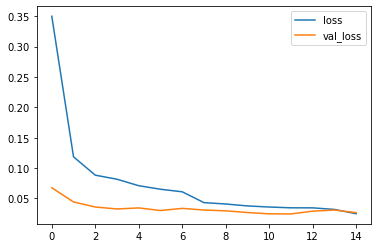

In [27]:
metrics[['loss' , 'val_loss']].plot()
plt.show()

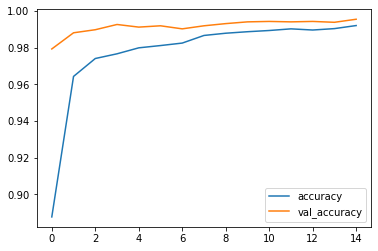

In [28]:
metrics[['accuracy' , 'val_accuracy']].plot()
plt.show()

<a id="section13"></a>
## Accuracy Report

Looks pretty good , now let's see our model's accuracy report !

In [29]:
model.evaluate(x_val_final, y_cat_val, verbose=0)

[0.0265106949955225, 0.9954761862754822]

In [30]:
y_pred=model.predict_classes(x_val_final)
y_pred

array([7, 7, 5, ..., 8, 1, 4])

In [31]:

print('Classification Report')
print(classification_report(y_val,y_pred))
print('\n')
print('Confusion Matrix')
print(confusion_matrix(y_val,y_pred))

Classification Report
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       417
           1       1.00      1.00      1.00       476
           2       1.00      0.99      1.00       384
           3       1.00      0.99      1.00       451
           4       1.00      0.99      1.00       391
           5       0.99      1.00      1.00       424
           6       1.00      0.99      0.99       403
           7       0.99      1.00      0.99       470
           8       0.99      0.99      0.99       383
           9       0.98      1.00      0.99       401

    accuracy                           1.00      4200
   macro avg       1.00      1.00      1.00      4200
weighted avg       1.00      1.00      1.00      4200



Confusion Matrix
[[417   0   0   0   0   0   0   0   0   0]
 [  0 476   0   0   0   0   0   0   0   0]
 [  0   0 382   0   0   0   0   1   1   0]
 [  0   0   0 448   0   0   0   1   0   2]
 [  0   1   0   0 389   0   

![](https://image.slidesharecdn.com/pacpresentation-111117202719-phpapp02/95/packaging-your-story-social-media-for-b2bs-59-728.jpg?cb=1328235125)

Prediction:
4


<function matplotlib.pyplot.show(*args, **kw)>

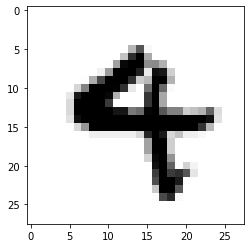

In [32]:
np.random.seed(22)
random_selection=np.random.randint(0,4201,size=1)
random_sample=x_val_final[random_selection]
print('Prediction:')
print(model.predict_classes(random_sample.reshape(1,28,28,1))[0])
plt.imshow(random_sample.reshape(28,28),cmap='binary')
plt.show

Prediction:
9


<function matplotlib.pyplot.show(*args, **kw)>

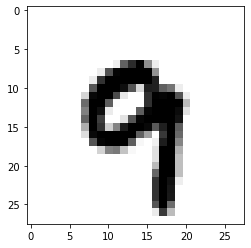

In [33]:
np.random.seed(20)
random_selection=np.random.randint(0,4201,size=1)
random_sample=x_val_final[random_selection]
print('Prediction:')
print(model.predict_classes(random_sample.reshape(1,28,28,1))[0])
plt.imshow(random_sample.reshape(28,28),cmap='binary')
plt.show

Prediction:
1


<function matplotlib.pyplot.show(*args, **kw)>

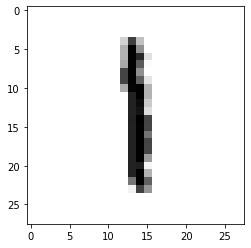

In [34]:
np.random.seed(19)
random_selection=np.random.randint(0,4201,size=1)
random_sample=x_val_final[random_selection]
print('Prediction:')
print(model.predict_classes(random_sample.reshape(1,28,28,1))[0])
plt.imshow(random_sample.reshape(28,28),cmap='binary')
plt.show

<a id="sectionlst"></a>
#  Submission


### [Back To Table of Contents](#toc_section)

So we are now on the last part ! Let's first make our test data all ready and then we will submit our predictions !

In [35]:
# Reshaping test data
x_test = test.values
x_test = x_test.reshape(28000,28,28)
x_test.shape

(28000, 28, 28)

In [36]:
x_test_scaled=x_test/255

In [37]:
test_predictions=model.predict_classes(x_test_scaled.reshape(28000,28,28,1))

In [38]:
test_predictions

array([2, 0, 9, ..., 3, 9, 2])

Let's convert these predictions into a submiitable csv file.

In [39]:
output=pd.DataFrame({'ImageId':test.index+1,'Label':test_predictions})
output.to_csv('new_submission.csv',index=False)

# Some last words:

### Thank you for reading! I'm still a beginner and want to improve myself in every way I can. So if you have any ideas to feedback please let me know in the comments section!


<div align='center'><font size="5" color="#000000"><b>And again please vote if you liked this notebook so it can reach more people, Thanks!</b></font></div>

![Thank you for reading](https://i.chzbgr.com/full/8599480832/hC37E5E67/thank-you-very-much)